In [1]:
%run ./Definitions.ipynb
!nvidia-smi
import os

2019-12-22 20:30:35.131442
thunder  Sun Dec 22 20:30:35 2019
[0] GeForce GTX 1080 Ti | 40'C,   0 % |    10 / 11178 MB |
[1] GeForce GTX 1080 Ti | 26'C,   0 % |    10 / 11178 MB |
[2] GeForce GTX 1080 Ti | 27'C,   0 % |    10 / 11178 MB |
[3] GeForce GTX 1080 Ti | 25'C,   0 % |    10 / 11178 MB |
[4] GeForce GTX 1080 Ti | 23'C,   0 % |    10 / 11178 MB |
[5] GeForce GTX 1080 Ti | 27'C,   0 % |    10 / 11178 MB |
[6] GeForce GTX 1080 Ti | 30'C,   0 % |    10 / 11178 MB |
[7] GeForce GTX 1080 Ti | 28'C,   0 % |    10 / 11178 MB |


/ds/environments/python2020/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
Using TensorFlow backend.
/ds/environments/python2020/lib/python3.7/site-packages/keras/callbacks/callbacks.py:19: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


Dataset consist of 85730 patients data with 6251 features for each patient
Function definitions executed
Definitions DONE !!

Sun Dec 22 20:30:48 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.01    Driver Version: 418.87.01    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:04:00.0 Off |                  N/A |
| 29%   41C    P0    59W / 250W |     10MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:06:00.0 Off |                  N/A |
| 29%   25C    P8     7W / 250W |     10Mi

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # so the IDs match nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"] = "0"   # choose here your GPU (0-7)

import tensorflow as tf
import tensorflow.compat.v1 as tf
import keras
# from keras import backend as K
import tensorflow.python.keras.backend as K


In [3]:
img_size = 250
red_size = 224

srcpath = '/ds2/data/retina/UK_BB/UK_BB_DATA/fundus/'
funduspath_CR = DATA_dir + 'Fundus_images_250_CR/'
trainpath = funduspath_CR + 'train/'
valpath = funduspath_CR + 'val/'
testpath = funduspath_CR + 'test/'

### LOAD valid train test and validation image names 

In [4]:
valid_traindf_names = pd.read_pickle(funduspath_CR + 'valid_traindf_names.pkl')
valid_valdf_names = pd.read_pickle(funduspath_CR + 'valid_valdf_names.pkl')
valid_testdf_names = pd.read_pickle(funduspath_CR + 'valid_testdf_names.pkl')

valid_traindf_names.shape , valid_valdf_names.shape , valid_testdf_names.shape

((101834, 5), (33943, 5), (33936, 5))

In [5]:
img_size = 250
red_size = 224

srcpath = '/ds2/data/retina/UK_BB/UK_BB_DATA/fundus/'
funduspath_CR = DATA_dir + 'Fundus_images_250_CR/'
trainpath = funduspath_CR + 'train/'
valpath = funduspath_CR + 'val/'
testpath = funduspath_CR + 'test/'

## Handling Imbalanced Data sets

In [6]:
which_gt = 4 # CHANGE 1,2,3,4 implies 'GT523', 'GT19', 'GTi', 'GTu'
n_NG = 0 # non glaucoma
n_G = 0  # glaucoma

GT_dict = {1:'GT523',2:'GT19',3:'GTi',4:'GTu'}
Class = GT_dict[which_gt]
temp = valid_traindf_names[Class]
for i in range(len(temp)):
    if(temp[i] == '1'):
        n_G += 1
    else:
        n_NG += 1
        
print("No. of Glaucoma patients in training set:",n_G)
print("No. of non-Glaucoma patients in training set:",n_NG)

No. of Glaucoma patients in training set: 2379
No. of non-Glaucoma patients in training set: 99455


### 1. Over Sampling Train set

In [7]:
# Oversample the minority class

X_train = valid_traindf_names['Fundus_Filenames']
y_train = valid_traindf_names[GT_dict[which_gt]]

# Converting class values to int 1 or 0
y_train = y_train.astype(int)

# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_glaucoma = X[X[Class]==0]
glaucoma = X[X[Class]==1]

# upsample minority
glaucoma_upsampled = resample(glaucoma,
                              replace=True, # sample with replacement
                              n_samples=len(not_glaucoma), # match number in majority class
                              random_state=42) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_glaucoma,glaucoma_upsampled])

# shuffle upsampled dataframe for training
upsampled = upsampled.sample(frac=1)


In [8]:
X[Class].value_counts()

0    99455
1     2379
Name: GTu, dtype: int64

In [9]:
upsampled[Class].value_counts()

1    99455
0    99455
Name: GTu, dtype: int64

#### validation distribution

In [10]:
valid_valdf_names[Class].value_counts()

0    33134
1      809
Name: GTu, dtype: int64

### Oversampling minority with less imbalance - in train set
Original imbalance ratio **X-** 1:40

Imbalance ratio **up1**-1:5, **up2**-1:10, **up3**-1:20, **up4**-1:30

Balanced ratio **upsampled**-1:1

In [11]:
# upsampling minority
glaucoma_up1 = resample(glaucoma, replace=True, # sample with replacement 
                        n_samples=floor(len(not_glaucoma)/5), # match number in majority class
                        random_state=42) # reproducible results

glaucoma_up2 = resample(glaucoma, replace=True, # sample with replacement 
                        n_samples=floor(len(not_glaucoma)/10), # match number in majority class
                        random_state=42) # reproducible results

glaucoma_up3 = resample(glaucoma, replace=True, # sample with replacement 
                        n_samples=floor(len(not_glaucoma)/20), # match number in majority class
                        random_state=42) # reproducible results

glaucoma_up4 = resample(glaucoma, replace=True, # sample with replacement 
                        n_samples=floor(len(not_glaucoma)/30), # match number in majority class
                        random_state=42) # reproducible results

# combine majority and upsampled minority
up1 = pd.concat([not_glaucoma,glaucoma_up1])
up2 = pd.concat([not_glaucoma,glaucoma_up2])
up3 = pd.concat([not_glaucoma,glaucoma_up3])
up4 = pd.concat([not_glaucoma,glaucoma_up4])

# shuffle upsampled dataframe for training
up1 = up1.sample(frac=1)
up2 = up2.sample(frac=1)
up3 = up3.sample(frac=1)
up4 = up4.sample(frac=1)


In [12]:
print("up1")
print(up1[Class].value_counts())
print("up2")
print(up2[Class].value_counts())
print("up1")
print(up3[Class].value_counts())
print("up4")
print(up4[Class].value_counts())

up1
0    99455
1    19891
Name: GTu, dtype: int64
up2
0    99455
1     9945
Name: GTu, dtype: int64
up1
0    99455
1     4972
Name: GTu, dtype: int64
up4
0    99455
1     3315
Name: GTu, dtype: int64


### 2. Class weight

In [13]:
# # Setting class weight for retraining:

# # compute_class_weight('balanced', np.unique(y_train), y_train)
# class_weight = [0.5, 2] # experiment with different values
n_NG , n_G

(99455, 2379)

## Define Model and Metrics

In [14]:
# reg_values = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6] # 1e-1, 
reg_value = 0.001
METRICS = [keras.metrics.BinaryAccuracy(name='Accuracy'),
           Precision, 
           Recall, 
           F1,
           keras.metrics.AUC(name='AUC')]

def mobilenet_model():       
    mobile_conv = MobileNet(weights='imagenet', include_top=False, input_shape=(red_size, red_size, 3))

    # UnFreeze last conv layer
    for layer in mobile_conv.layers[:78]:
        layer.trainable = False
    for layer in mobile_conv.layers[78:]:
        layer.trainable = True
        
    # Create the model
    model = models.Sequential()
    model.add(mobile_conv)
 
    # Add new layers
    # https://adventuresinmachinelearning.com/global-average-pooling-convolutional-neural-networks/
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(1, activation='sigmoid'))
 
    return model

### Augmentation
https://nbviewer.jupyter.org/github/aleju/imgaug-doc/blob/master/notebooks/A01%20-%20Load%20and%20Augment%20an%20Image.ipynb

In [15]:
seq = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Affine(scale=1.1),
    iaa.Affine(rotate=(-10, 10)),
    # iaa.GammaContrast(0.9),
    iaa.Resize({"height": 230, "width": 230}),
    iaa.CropToFixedSize(width=red_size, height=red_size)
    ])

### Flow from Dataframe
https://www.kaggle.com/dmitrypukhov/cnn-with-imagedatagenerator-flow-from-dataframe

Normalizing using ImageDataGenerator https://stackoverflow.com/questions/41855512/how-does-data-normalization-work-in-keras-during-prediction

### Converting the dataframe classes to integers

In [16]:
valid_traindf_names[Class] = valid_traindf_names[Class].astype(int)
valid_valdf_names[Class] = valid_valdf_names[Class].astype(int)

In [17]:
# To use same settings as mobilenet
# from keras.applications.mobilenet import preprocess_input
# train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)

train_datagen = ImageDataGenerator(preprocessing_function=seq.augment_image, samplewise_center=True,
                                   featurewise_center=True, featurewise_std_normalization=True,
                                   rescale= 1./127.5-1) 
val_datagen = ImageDataGenerator(samplewise_center=True,
                                 featurewise_center=True, featurewise_std_normalization=True,
                                 rescale=1./127.5-1)  
BATCH_SIZE = 32

print("\nOriginal imbalanced train data: ")
imb_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = valid_traindf_names, # imbalanced train dataframe
    directory=trainpath,
    x_col=valid_traindf_names.columns[0],
    y_col=valid_traindf_names.columns[which_gt],
#     x_col = upsampled.columns[0], # upsampled data
#     y_col = upsampled.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nOriginal validation data: ")
validation_generator = val_datagen.flow_from_dataframe(
    dataframe=valid_valdf_names,
    directory=valpath,
    x_col=valid_valdf_names.columns[0],
    y_col=valid_valdf_names.columns[which_gt],
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUpsampled train data 1:1 ")
up_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = upsampled, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = upsampled.columns[0], # upsampled data
    y_col = upsampled.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUP1 train data 1:5 ")
up1_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = up1, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = up1.columns[0], # upsampled data
    y_col = up1.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUP2 train data 1:10 ")
up2_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = up2, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = up2.columns[0], # upsampled data
    y_col = up2.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUP3 train data 1:20 ")
up3_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = up3, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = up3.columns[0], # upsampled data
    y_col = up3.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUP4 train data 1:30 ")
up4_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = up4, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = up4.columns[0], # upsampled data
    y_col = up4.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)



Original imbalanced train data: 
Found 101834 validated image filenames.

Original validation data: 
Found 33943 validated image filenames.

Upsampled train data 1:1 
Found 198910 validated image filenames.

UP1 train data 1:5 
Found 119346 validated image filenames.

UP2 train data 1:10 
Found 109400 validated image filenames.

UP3 train data 1:20 
Found 104427 validated image filenames.

UP4 train data 1:30 
Found 102770 validated image filenames.


### Choosing parameters and model compile

In [18]:
which_model = mobilenet_model
# which_model = vgg_model

model = which_model()
learning_rate  = 0.0001 
decay = 1e-5
momentum=0.9
opt = Adam(lr=learning_rate, decay = decay) 
model.compile(loss='binary_crossentropy', metrics=METRICS, optimizer=opt)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 3,229,889
Trainable params: 1,589,249
Non-trainable params: 1,640,640
_________________________________________________________________


In [19]:
# With L2 weight regularizer
# es = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.000001, verbose=1)
n_epochs=200
n_steps_per_epoch = 50
n_validation_steps = 10

### Train with upsampled data (1:1)

In [20]:
# start = time.time()
# up_history = model.fit_generator(up_train_generator, 
#                               epochs=n_epochs, 
#                               steps_per_epoch=n_steps_per_epoch,
#                               validation_data=validation_generator,
#                               validation_steps=n_validation_steps, 
#                               callbacks=[reduce_lr]
#                              )
# end = time.time()

In [21]:
# print("Time taken:",end-start)

In [22]:
# plt.figure(figsize=(10,10))
# plot_metrics(up_history)

### Train with UP2 (1:10)

In [23]:
# start = time.time()
# up2_history = model.fit_generator(up2_train_generator, 
#                               epochs=n_epochs, 
#                               steps_per_epoch=n_steps_per_epoch,
#                               validation_data=validation_generator,
#                               validation_steps=n_validation_steps,
#                               class_weight = [1.5,0.5],
#                               callbacks=[reduce_lr]
#                              )
# end = time.time()

In [24]:
# print("Time taken:",end-start)

In [25]:
# plt.figure(figsize=(10,10))
# plot_metrics(up2_history)

### Train with UP3 (1:20)

In [26]:
start = time.time()
up3_history = model.fit_generator(up3_train_generator, 
                              epochs=n_epochs, 
                              steps_per_epoch=n_steps_per_epoch,
                              validation_data=validation_generator,
                              validation_steps=n_validation_steps, 
                              # class_weight = {0:0.5,1:3},
                              callbacks=[reduce_lr]
                             )
end = time.time()

/ds/environments/python2020/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:339: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if not isinstance(values, collections.Sequence):


Epoch 1/200


/ds/environments/python2020/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/ds/environments/python2020/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


50/50 [==============================] - 21s 424ms/step - loss: 0.3989 - Accuracy: 0.8269 - Precision: 0.0336 - Recall: 0.1567 - F1: 0.0506 - AUC: 0.5499 - val_loss: 0.9352 - val_Accuracy: 0.2594 - val_Precision: 0.0373 - val_Recall: 0.6000 - val_F1: 0.0691 - val_AUC: 0.6181
Epoch 2/200
50/50 [==============================] - 18s 351ms/step - loss: 0.1918 - Accuracy: 0.9556 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.5595 - val_loss: 0.0643 - val_Accuracy: 0.9656 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.4909
Epoch 3/200
50/50 [==============================] - 19s 372ms/step - loss: 0.2066 - Accuracy: 0.9500 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.6204 - val_loss: 0.0687 - val_Accuracy: 0.9812 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5828
Epoch 4/200
50/50 [==============================] - 20s 404ms/step - loss: 0.1906 - Accuracy: 0.954

Epoch 28/200
50/50 [==============================] - 19s 383ms/step - loss: 0.1845 - Accuracy: 0.9456 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.7618 - val_loss: 0.7190 - val_Accuracy: 0.5813 - val_Precision: 0.0063 - val_Recall: 0.0333 - val_F1: 0.0105 - val_AUC: 0.3578
Epoch 29/200
50/50 [==============================] - 20s 405ms/step - loss: 0.1779 - Accuracy: 0.9506 - Precision: 0.0200 - Recall: 0.0050 - F1: 0.0080 - AUC: 0.7166 - val_loss: 0.6762 - val_Accuracy: 0.5781 - val_Precision: 0.0558 - val_Recall: 0.5667 - val_F1: 0.0999 - val_AUC: 0.7311
Epoch 30/200
50/50 [==============================] - 20s 406ms/step - loss: 0.1563 - Accuracy: 0.9594 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.7105 - val_loss: 0.6534 - val_Accuracy: 0.5562 - val_Precision: 0.0059 - val_Recall: 0.0500 - val_F1: 0.0105 - val_AUC: 0.5597
Epoch 31/200
50/50 [==============================] - 22s 447ms/step - loss: 0.1936 - Accuracy: 0.9450 - Prec

50/50 [==============================] - 22s 444ms/step - loss: 0.1823 - Accuracy: 0.9500 - Precision: 0.0200 - Recall: 0.0067 - F1: 0.0100 - AUC: 0.7239 - val_loss: 0.7501 - val_Accuracy: 0.5125 - val_Precision: 0.0422 - val_Recall: 0.5500 - val_F1: 0.0774 - val_AUC: 0.5690
Epoch 56/200
50/50 [==============================] - 19s 387ms/step - loss: 0.1668 - Accuracy: 0.9531 - Precision: 0.0200 - Recall: 0.0100 - F1: 0.0133 - AUC: 0.7754 - val_loss: 0.7888 - val_Accuracy: 0.4781 - val_Precision: 0.0343 - val_Recall: 0.4000 - val_F1: 0.0626 - val_AUC: 0.8718
Epoch 57/200
50/50 [==============================] - 20s 401ms/step - loss: 0.1544 - Accuracy: 0.9575 - Precision: 0.0200 - Recall: 0.0100 - F1: 0.0133 - AUC: 0.7794 - val_loss: 0.7263 - val_Accuracy: 0.4344 - val_Precision: 0.0231 - val_Recall: 0.2500 - val_F1: 0.0417 - val_AUC: 0.4701
Epoch 58/200
50/50 [==============================] - 22s 439ms/step - loss: 0.1448 - Accuracy: 0.9644 - Precision: 0.0200 - Recall: 0.0067 - F1: 

Epoch 83/200
50/50 [==============================] - 20s 391ms/step - loss: 0.1735 - Accuracy: 0.9531 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.7144 - val_loss: 0.7450 - val_Accuracy: 0.5094 - val_Precision: 0.0205 - val_Recall: 0.2000 - val_F1: 0.0369 - val_AUC: 0.4205
Epoch 84/200
50/50 [==============================] - 23s 456ms/step - loss: 0.1847 - Accuracy: 0.9469 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.7435 - val_loss: 0.6870 - val_Accuracy: 0.4812 - val_Precision: 0.0130 - val_Recall: 0.1500 - val_F1: 0.0238 - val_AUC: 0.6046
Epoch 85/200
50/50 [==============================] - 19s 382ms/step - loss: 0.1495 - Accuracy: 0.9606 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.7439 - val_loss: 0.7820 - val_Accuracy: 0.5469 - val_Precision: 0.0083 - val_Recall: 0.1000 - val_F1: 0.0154 - val_AUC: 0.3548
Epoch 86/200
50/50 [==============================] - 19s 387ms/step - loss: 0.1544 - Accuracy: 0

50/50 [==============================] - 20s 391ms/step - loss: 0.1849 - Accuracy: 0.9488 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.7215 - val_loss: 0.7097 - val_Accuracy: 0.5031 - val_Precision: 0.0534 - val_Recall: 0.5500 - val_F1: 0.0964 - val_AUC: 0.6626
Epoch 111/200
50/50 [==============================] - 22s 447ms/step - loss: 0.1727 - Accuracy: 0.9538 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.7179 - val_loss: 0.7139 - val_Accuracy: 0.4906 - val_Precision: 0.0274 - val_Recall: 0.4000 - val_F1: 0.0508 - val_AUC: 0.6042
Epoch 112/200
50/50 [==============================] - 19s 381ms/step - loss: 0.1663 - Accuracy: 0.9538 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.7438 - val_loss: 0.6681 - val_Accuracy: 0.5906 - val_Precision: 0.0361 - val_Recall: 0.4000 - val_F1: 0.0661 - val_AUC: 0.8095
Epoch 113/200
50/50 [==============================] - 20s 398ms/step - loss: 0.1670 - Accuracy: 0.9525 - Pr

50/50 [==============================] - 23s 458ms/step - loss: 0.1731 - Accuracy: 0.9525 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.7189 - val_loss: 0.6351 - val_Accuracy: 0.5375 - val_Precision: 0.0388 - val_Recall: 0.5500 - val_F1: 0.0715 - val_AUC: 0.6802
Epoch 138/200
50/50 [==============================] - 18s 369ms/step - loss: 0.1721 - Accuracy: 0.9475 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.7933 - val_loss: 0.7444 - val_Accuracy: 0.5063 - val_Precision: 0.0415 - val_Recall: 0.6000 - val_F1: 0.0765 - val_AUC: 0.6188
Epoch 139/200
50/50 [==============================] - 19s 382ms/step - loss: 0.1389 - Accuracy: 0.9625 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.7795 - val_loss: 0.7836 - val_Accuracy: 0.4844 - val_Precision: 0.0307 - val_Recall: 0.5000 - val_F1: 0.0578 - val_AUC: 0.6378
Epoch 140/200
50/50 [==============================] - 23s 452ms/step - loss: 0.1761 - Accuracy: 0.9500 - Pr

50/50 [==============================] - 22s 442ms/step - loss: 0.1532 - Accuracy: 0.9525 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.8339 - val_loss: 0.6807 - val_Accuracy: 0.5594 - val_Precision: 0.0274 - val_Recall: 0.4000 - val_F1: 0.0512 - val_AUC: 0.6733
Epoch 165/200
50/50 [==============================] - 19s 379ms/step - loss: 0.1495 - Accuracy: 0.9556 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.8272 - val_loss: 0.7707 - val_Accuracy: 0.4656 - val_Precision: 0.0333 - val_Recall: 0.4000 - val_F1: 0.0597 - val_AUC: 0.4906
Epoch 166/200
50/50 [==============================] - 20s 393ms/step - loss: 0.1756 - Accuracy: 0.9500 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.7740 - val_loss: 0.7294 - val_Accuracy: 0.5031 - val_Precision: 0.0169 - val_Recall: 0.3000 - val_F1: 0.0320 - val_AUC: 0.4641
Epoch 167/200
50/50 [==============================] - 22s 438ms/step - loss: 0.1643 - Accuracy: 0.9538 - Pr

50/50 [==============================] - 22s 436ms/step - loss: 0.1780 - Accuracy: 0.9519 - Precision: 0.0200 - Recall: 0.0200 - F1: 0.0200 - AUC: 0.7335 - val_loss: 0.7237 - val_Accuracy: 0.6156 - val_Precision: 0.0229 - val_Recall: 0.2000 - val_F1: 0.0408 - val_AUC: 0.5433
Epoch 192/200
50/50 [==============================] - 19s 389ms/step - loss: 0.1755 - Accuracy: 0.9488 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.7787 - val_loss: 0.6235 - val_Accuracy: 0.5875 - val_Precision: 0.0071 - val_Recall: 0.1000 - val_F1: 0.0133 - val_AUC: 0.4089
Epoch 193/200
50/50 [==============================] - 20s 392ms/step - loss: 0.1629 - Accuracy: 0.9544 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.7742 - val_loss: 0.6571 - val_Accuracy: 0.5562 - val_Precision: 0.0306 - val_Recall: 0.3000 - val_F1: 0.0546 - val_AUC: 0.5255
Epoch 194/200
50/50 [==============================] - 21s 425ms/step - loss: 0.1685 - Accuracy: 0.9513 - Precision: 0.0

In [27]:
print("Time taken:",end-start)

Time taken: 4015.757524251938


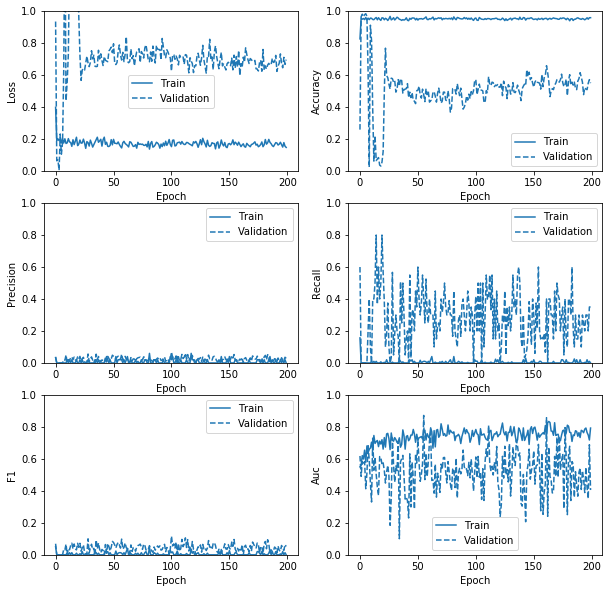

In [28]:
plt.figure(figsize=(10,10))
plot_metrics(up3_history)

### Train with UP4 (1:30)

In [29]:
# start = time.time()
# up4_history = model.fit_generator(up4_train_generator, 
#                               epochs=n_epochs, 
#                               steps_per_epoch=n_steps_per_epoch,
#                               validation_data=validation_generator,
#                               validation_steps=n_validation_steps, 
#                               callbacks=[reduce_lr]
#                              )
# end = time.time()

In [30]:
# print("Time taken:",end-start)

In [31]:
# plt.figure(figsize=(10,10))
# plot_metrics(up4_history)

### Train with Imbalanced original train data (1:40)

In [32]:
start = time.time()
imb_history = model.fit_generator(imb_train_generator,
                                  epochs=n_epochs,
                                  steps_per_epoch=n_steps_per_epoch,
                                  validation_data=validation_generator,
                                  validation_steps=n_validation_steps,
                                  # class_weight = {0:0.5,1:6},
                                  callbacks=[reduce_lr]
                                 )
end = time.time()

Epoch 1/200
50/50 [==============================] - 20s 404ms/step - loss: 0.0985 - Accuracy: 0.9800 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.7446 - val_loss: 0.6723 - val_Accuracy: 0.6125 - val_Precision: 0.0422 - val_Recall: 0.4000 - val_F1: 0.0750 - val_AUC: 0.5346
Epoch 2/200
50/50 [==============================] - 24s 471ms/step - loss: 0.1002 - Accuracy: 0.9806 - Precision: 0.0200 - Recall: 0.0200 - F1: 0.0200 - AUC: 0.7394 - val_loss: 0.7243 - val_Accuracy: 0.5781 - val_Precision: 0.0144 - val_Recall: 0.1000 - val_F1: 0.0251 - val_AUC: 0.3716
Epoch 3/200
50/50 [==============================] - 19s 390ms/step - loss: 0.1076 - Accuracy: 0.9762 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.7735 - val_loss: 0.6174 - val_Accuracy: 0.6094 - val_Precision: 0.0202 - val_Recall: 0.2500 - val_F1: 0.0369 - val_AUC: 0.6096
Epoch 4/200
50/50 [==============================] - 19s 381ms/step - loss: 0.1266 - Accuracy: 0.9700 - Precisio

50/50 [==============================] - 19s 389ms/step - loss: 0.1012 - Accuracy: 0.9794 - Precision: 0.0200 - Recall: 0.0200 - F1: 0.0200 - AUC: 0.6728 - val_loss: 0.5220 - val_Accuracy: 0.8344 - val_Precision: 0.0250 - val_Recall: 0.0500 - val_F1: 0.0333 - val_AUC: 0.6004
Epoch 29/200
50/50 [==============================] - 23s 461ms/step - loss: 0.1069 - Accuracy: 0.9769 - Precision: 0.0200 - Recall: 0.0200 - F1: 0.0200 - AUC: 0.7040 - val_loss: 0.5139 - val_Accuracy: 0.8844 - val_Precision: 0.1000 - val_Recall: 0.1000 - val_F1: 0.1000 - val_AUC: 0.5082
Epoch 30/200
50/50 [==============================] - 19s 386ms/step - loss: 0.1068 - Accuracy: 0.9744 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.7723 - val_loss: 0.5317 - val_Accuracy: 0.8875 - val_Precision: 0.0417 - val_Recall: 0.2000 - val_F1: 0.0686 - val_AUC: 0.7749
Epoch 31/200
50/50 [==============================] - 20s 394ms/step - loss: 0.1216 - Accuracy: 0.9712 - Precision: 0.0000e+00 - Recal

Epoch 55/200
50/50 [==============================] - 24s 484ms/step - loss: 0.0742 - Accuracy: 0.9850 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.7499 - val_loss: 0.4495 - val_Accuracy: 0.9219 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.4761
Epoch 56/200
50/50 [==============================] - 19s 379ms/step - loss: 0.1203 - Accuracy: 0.9719 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.7168 - val_loss: 0.5158 - val_Accuracy: 0.9187 - val_Precision: 0.0500 - val_Recall: 0.1000 - val_F1: 0.0667 - val_AUC: 0.8197
Epoch 57/200
50/50 [==============================] - 19s 381ms/step - loss: 0.1092 - Accuracy: 0.9762 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.6768 - val_loss: 0.4697 - val_Accuracy: 0.9312 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.2382
Epoch 58/200
50/50 [==============================] - 23s 470ms/step - lo

50/50 [==============================] - 24s 483ms/step - loss: 0.1229 - Accuracy: 0.9706 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.7197 - val_loss: 0.4579 - val_Accuracy: 0.9250 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5478
Epoch 82/200
50/50 [==============================] - 19s 382ms/step - loss: 0.1037 - Accuracy: 0.9762 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.7287 - val_loss: 0.4477 - val_Accuracy: 0.9406 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.3734
Epoch 83/200
50/50 [==============================] - 19s 388ms/step - loss: 0.1031 - Accuracy: 0.9787 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.6442 - val_loss: 0.4231 - val_Accuracy: 0.9250 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.4439
Epoch 84/200
50/50 [==============================] - 23s 461ms/step - los

50/50 [==============================] - 26s 510ms/step - loss: 0.1149 - Accuracy: 0.9725 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.7425 - val_loss: 0.4341 - val_Accuracy: 0.9325 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5429
Epoch 108/200
50/50 [==============================] - 19s 370ms/step - loss: 0.1115 - Accuracy: 0.9756 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.6676 - val_loss: 0.4521 - val_Accuracy: 0.9781 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.1536
Epoch 109/200
50/50 [==============================] - 20s 393ms/step - loss: 0.1187 - Accuracy: 0.9750 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.6072 - val_loss: 0.3998 - val_Accuracy: 0.9594 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5886
Epoch 110/200
50/50 [==============================] - 23s 461ms/step - 

50/50 [==============================] - 23s 464ms/step - loss: 0.1066 - Accuracy: 0.9737 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.7726 - val_loss: 0.4100 - val_Accuracy: 0.9281 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5228
Epoch 134/200
50/50 [==============================] - 20s 396ms/step - loss: 0.1048 - Accuracy: 0.9769 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.7039 - val_loss: 0.4080 - val_Accuracy: 0.9625 - val_Precision: 0.0500 - val_Recall: 0.0500 - val_F1: 0.0500 - val_AUC: 0.4956
Epoch 135/200
50/50 [==============================] - 20s 397ms/step - loss: 0.1051 - Accuracy: 0.9750 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.7593 - val_loss: 0.4082 - val_Accuracy: 0.9625 - val_Precision: 0.0500 - val_Recall: 0.0333 - val_F1: 0.0400 - val_AUC: 0.6314
Epoch 136/200
50/50 [==============================] - 23s 457ms/step - loss: 0.0922 - Accuracy:

50/50 [==============================] - 22s 447ms/step - loss: 0.0957 - Accuracy: 0.9769 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.7939 - val_loss: 0.4261 - val_Accuracy: 0.9375 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.4148
Epoch 160/200
50/50 [==============================] - 19s 386ms/step - loss: 0.1096 - Accuracy: 0.9769 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.6204 - val_loss: 0.4416 - val_Accuracy: 0.9531 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5218
Epoch 161/200
50/50 [==============================] - 20s 399ms/step - loss: 0.1086 - Accuracy: 0.9756 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.6849 - val_loss: 0.3855 - val_Accuracy: 0.9594 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.7545
Epoch 162/200
50/50 [==============================] - 24s 474ms/step - 

50/50 [==============================] - 23s 470ms/step - loss: 0.1149 - Accuracy: 0.9750 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.6609 - val_loss: 0.4110 - val_Accuracy: 0.9500 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6152
Epoch 186/200
50/50 [==============================] - 19s 387ms/step - loss: 0.0942 - Accuracy: 0.9800 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.6790 - val_loss: 0.4176 - val_Accuracy: 0.9469 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5243
Epoch 187/200
50/50 [==============================] - 24s 486ms/step - loss: 0.0969 - Accuracy: 0.9775 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.7355 - val_loss: 0.4185 - val_Accuracy: 0.9719 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.3865
Epoch 188/200
50/50 [==============================] - 19s 382ms/step - 

In [33]:
print("Time taken:",end-start)

Time taken: 4158.967533826828


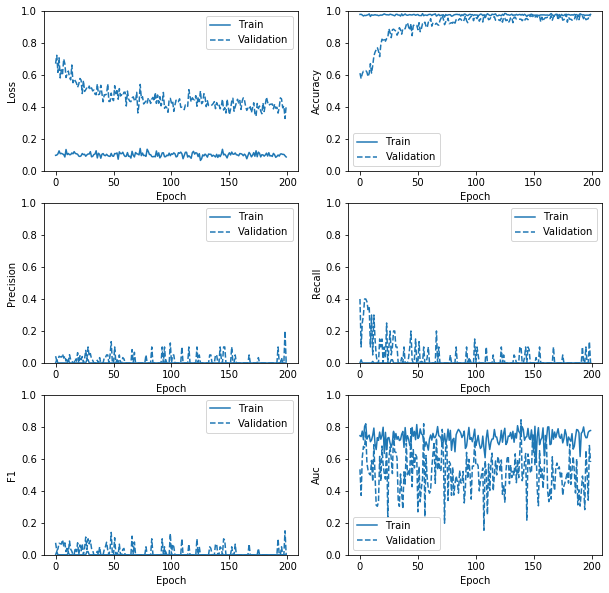

In [34]:
plt.figure(figsize=(10,10))
plot_metrics(imb_history)

## Evaluation

In [35]:
results_tr = model.evaluate(imb_train_generator,steps=100)
results_vl = model.evaluate(validation_generator,steps=100)

100/100 [==============================] - 19s 193ms/step


In [36]:
print("NAME :\tTRAIN :\tVALIDATION ")
for name, value_tr, value_vl in zip(model.metrics_names, results_tr, results_vl):
    print("%s : %5.3f : %7.3f" %(name, value_tr , value_vl))

# without classweights:
# NAME :	TRAIN :	VALIDATION 
# loss : 0.754 :   0.465
# Accuracy : 0.531 :   0.866
# Precision : 0.006 :   0.006
# Recall : 0.070 :   0.040
# F1 : 0.011 :   0.010
# AUC : 0.565 :   0.544

NAME :	TRAIN :	VALIDATION 
loss : 0.254 :   0.363
Accuracy : 0.969 :   0.970
Precision : 0.000 :   0.010
Recall : 0.000 :   0.005
F1 : 0.000 :   0.007
AUC : 0.504 :   0.494


## Prediction
The output of a binary classification is the probability of a sample belonging to a class.

In [37]:
# PREDICTED LABELS
start = time.time()
pred_tr = model.predict(imb_train_generator)
tr_end = time.time()
pred_vl = model.predict(validation_generator)
vl_end = time.time()

tr_end-start , vl_end-tr_end

(1329.2336082458496, 215.28767371177673)

In [38]:
# np.save(funduspath_CR + str(n_epochs) + 'ep_traintwice_newtr.npy', pred_tr)
# np.save(funduspath_CR + str(n_epochs) + 'ep_traintwice_newvl.npy', pred_vl)

In [39]:
# val_class = []
# for i, predicted in enumerate(pred_vl):
#     if predicted[0] > 0.1:
#         #assign i to class 1
#         val_class.append(1)
#     else:
#         #assign i to class 0
#         val_class.append(0)

In [40]:
# TRUE LABELS

train_labels = valid_traindf_names[Class].tolist()
train_labels = [int(i) for i in train_labels]

val_labels = valid_valdf_names[Class].tolist()
val_labels = [int(i) for i in val_labels]


### ROC Curve

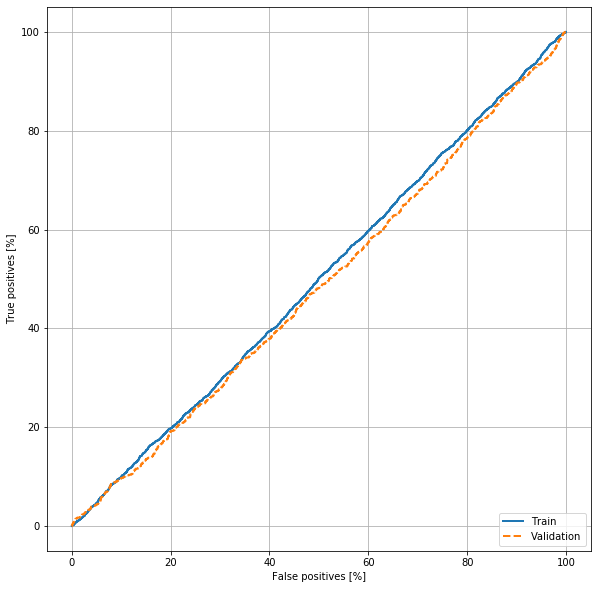

In [41]:
plt.figure(figsize=(10,10))
plot_roc("Train", train_labels, pred_tr, color=colors[0])
plot_roc("Validation", val_labels, pred_vl, color=colors[1],linestyle='--')
# plot_roc("Validation", val_labels, val_class, color=colors[3],linestyle='-.') # theshold 0.1
plt.legend(loc='lower right')

### Confusion matrix

Train data: 
TN: 98910 
FP: 545 
FN: 2368 
TP: 11


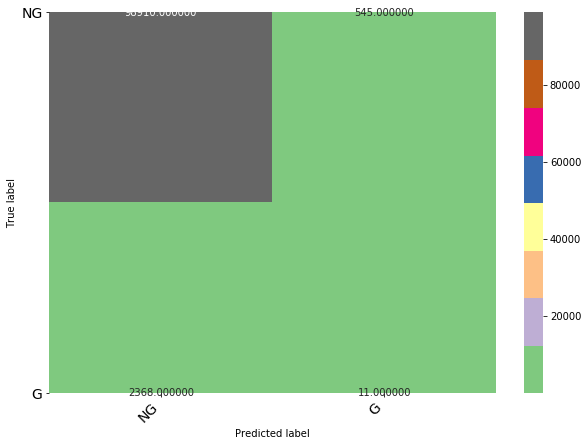

In [42]:
tn, fp, fn, tp = confusion_matrix(train_labels, pred_tr > 0.5).ravel()
train_cm = [tn, fp, fn, tp]
print("Train data: \nTN:",tn,"\nFP:",fp,"\nFN:",fn,"\nTP:",tp)
cm = confusion_matrix(train_labels, pred_tr > 0.5)
print_confusion_matrix(cm, ['NG','G'])

Validation data: 
TN: 32792 
FP: 342 
FN: 796 
TP: 13


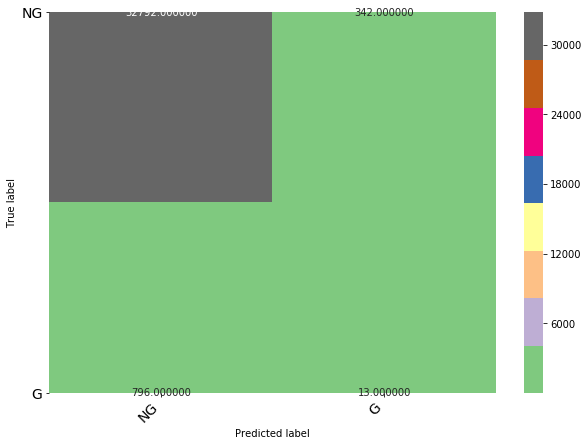

In [43]:
tn, fp, fn, tp = confusion_matrix(val_labels, pred_vl > 0.5).ravel()
val_cm = [tn, fp, fn, tp]
print("Validation data: \nTN:",tn,"\nFP:",fp,"\nFN:",fn,"\nTP:",tp)
cm = confusion_matrix(val_labels, pred_vl > 0.5)
print_confusion_matrix(cm, ['NG','G'])

### MLFlow 

In [51]:
# get_notebook_name()

<IPython.core.display.Javascript object>

'CNN Fundus- train_twice-Copy7 nocw.ipynb'

In [50]:
# history = up3_history
# tag_value = get_notebook_name()

# exp_name = get_notebook_name()+"-run at-"+datetime.datetime.now().strftime("%d%b%Y %H:%M")
# keras_model_path = funduspath_CR+ exp_name + '_model'
# save_mlflow(keras_model_path,exp_name,which_gt,which_model,seq,BATCH_SIZE,
#             n_epochs,n_steps_per_epoch,n_validation_steps,
#             reg_value,learning_rate,decay,opt,
#             history,results_tr,results_vl,train_cm,val_cm
#            )

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [52]:
# client = MlflowClient()
# run = client.create_run('23')
# client.set_tag(run.info.run_id, "tag_key", tag_value)